# Build an interface between deepXDE and Altair Simulation

In [1]:
import numpy as np
import pandas as pd
from pyNastran.op2.op2 import read_op2
from pyNastran.op2.op2_geom import read_op2_geom
import pyvista as pv
import trimesh

import deepxde as dde

from  pinnDSE.geom import MeshGeom
from pinnDSE.viz import *

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


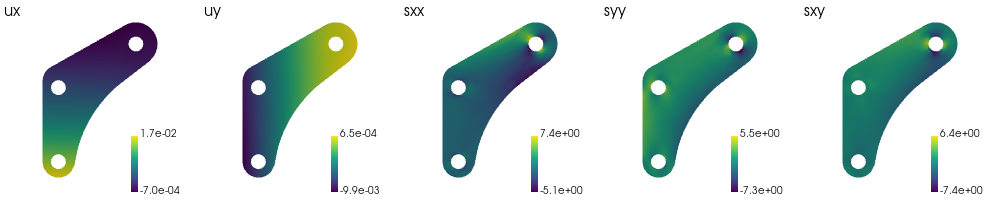

In [2]:
op2File = 'data/controlArm/v1.0/controlArm01_nom.op2'
g = MeshGeom(op2File)
plotScalarFields(g.mesh, g.resDf)

In [ ]:
def getEdgeNormals(bnd):
    perp = [0,0,1]
    edgeNormals = np.zeros((bnd.n_cells,3))
    com = np.mean(bnd.points, axis=0)
    dirs = np.zeros(bnd.n_cells)

    # get first normal
    vi,vj = bnd.extract_cells(0).points
    nv = np.cross(vi-vj,np.array(perp))
    edgeNormals[0,:] = nv / np.linalg.norm(nv)

    # get the rest
    for eid in range(1, bnd.n_cells):
        vi,vj = bnd.extract_cells(eid).points
        nv = np.cross(vi-vj,np.array(perp))
        nv /= np.linalg.norm(nv)
        nv *= np.sign(np.dot(nv,edgeNormals[eid-1,:]))
        edgeNormals[eid,:] = nv
        dirs[eid] = np.dot(0.5*(vi+vj)-com, nv)

    edgeNormals = edgeNormals * np.sign(np.mean(dirs)) # point outwards
    
    return edgeNormals

def getEdgeLength(bnd):
    L = 0
    for eid in range(1, bnd.n_cells):
        vi,vj = bnd.extract_cells(eid).points
        L += np.linalg.norm(vi-vj)
    return L
    
def force2Traction(bnd, F, t):
    L = getEdgeLength(bnd)
    return F/(L*t)

def sampleDomain(mesh, N, seed=1234):
    tmesh = pyvistaToTrimesh(mesh)
    np.random.seed(seed)
    samples, face_index = trimesh.sample.sample_surface_even(tmesh, N)
    return samples

def sampleBoundary(bnd, N, includeNormals=False, seed=1234):
    np.random.seed(seed)
    samples = np.zeros((N,3))
    
    if includeNormals:
        normals = np.zeros((N,3))
        edgeNormals = getEdgeNormals(bnd)
        
    for n in range(N):
        eid = np.random.choice(range(bnd.n_cells))
        edge = bnd.extract_cells(eid)
        vi,vj = edge.points
        w = np.random.rand()
        p = w*vi+(1-w)*vj
        samples[n,:] = p
        
        if includeNormals:
            normals[n,:] = edgeNormals[eid,:]
        
    if includeNormals:
        return samples, normals

    return samples

def plotField(x, mesh=None, scalar=None, interpolate=False):
    # point coordinates
    pc = pv.PolyData(addZ(x))

    plotter = pv.Plotter(border=False)
    plotter.set_background('white')
    if interpolate:
        pc['field'] = scalar
        vertScalars = mesh.copy().interpolate(pc)['field']
        plotter.add_mesh(mesh, show_edges=False, scalars=vertScalars)
        plotter.add_scalar_bar(n_labels=2, label_font_size=10, width=0.1, height=0.3, 
                                   vertical=True, position_x=0.65, fmt="%.1e", color='k')
    else:
        if mesh is not None:
            plotter.add_mesh(mesh, show_edges=False)
        if scalar is not None:
            plotter.add_mesh(pc, render_points_as_spheres=True, scalars=scalar)
            plotter.add_scalar_bar(n_labels=2, label_font_size=10, width=0.1, height=0.3, 
                                   vertical=True, position_x=0.65, fmt="%.1e", color='k')
        else:
            plotter.add_mesh(pc, render_points_as_spheres=True, color='gray')
    
    plotter.show(window_size=(400,400), cpos='xy');
    
def addZ(x):
    return np.hstack([x,np.zeros((x.shape[0],1))])
    

op2File = 'data/controlArm/v1.0/controlArm01_nom.op2'
mesh = loadOptistructModel(op2File)
resDf = loadOptistructResults(op2File, loadNodalStress=True)


# op2File = 'data/controlArm/v1.0/controlArm01_high.op2'
# resDfH = loadOptistructResults(op2File, loadNodalStress=True)
# meshH = loadOptistructModel(op2File)

# op2File = 'data/controlArm/v1.0/controlArm01_low.op2'
# resDfL = loadOptistructResults(op2File, loadNodalStress=True)
# meshL = loadOptistructModel(op2File)

# plotScalarFields(meshL, resDfL)
plotScalarFields(mesh, resDf)
# plotScalarFields(meshH, resDfH)

In [ ]:
resDf

In [ ]:
resDf = resDf.rename(columns={'t1':'ux', 't2':'uy', 'oxx':'sxx', 
                      'oyy':'syy','txy':'sxy', 'von_mises':'vonMises'})

In [ ]:
plotter = pv.Plotter(border=False)
plotter.set_background('white')
plotter.add_mesh(mesh, show_edges=False)

# sample domain
samples = sampleDomain(mesh, 300)
pc = pv.PolyData(samples)
plotter.add_mesh(pc, render_points_as_spheres=True, color='gray')

# sample boundary
bndDict = getAllBoundaries(mesh)
for bndId, color in zip(bndDict.keys(), ['red', 'green', 'blue', 'yellow']):
    samples, normals = sampleBoundary(bndDict[bndId], 100, includeNormals=True)
    pc = pv.PolyData(samples)
    plotter.add_mesh(pc, render_points_as_spheres=True, color=color)
    plotter.add_arrows(samples, normals, 0.1, color=color)

plotter.show(window_size=(400,400), cpos='xy');

# Test on Poisson Problem

In [ ]:
# import deepxde as dde
import deepxde as dde

In [ ]:
#################################################
class MeshGeom(dde.geometry.geometry.Geometry):
    def __init__(self, op2File):
        self.dim = 2
        self.idstr = 'MeshGeom'
#         self.resDf = loadOptistructResults(op2File, loadNodalStress=True)
        self.mesh = loadOptistructModel(op2File)
        self.bndDict = getAllBoundaries(self.mesh)

    
    def random_points(self, n, random="pseudo", seed=1234):
        samples = sampleDomain(self.mesh, n, seed=seed)
        return samples[:,:2]
    
    def random_boundary_points(self, n, bndId, random="pseudo", seed=1234):
        samples, normals = sampleBoundary(self.bndDict[bndId], n, includeNormals=True, seed=1234)
        return samples[:,:2], normals[:,:2]

#################################################
class TractionBC(dde.boundary_conditions.BC):
    def __init__(self, geom, func, boundary, T):
        self.geom = geom
        self.func = func
        self.T = T
        
    def error(self, train_x, inputs, outputs, beg, end):
        return self.func(train_x, inputs, outputs, self.train_n, self.T)[beg:end]
    
#################################################
class PDE2(dde.data.pde.PDE):
    def __init__(
        self,
        geometry,
        pde,
        bcs,
        num_domain=0,
        num_boundary_dir={},
        train_distribution="sobol",
        anchors=None,
        exclusions=None,
        solution=None,
        num_test=None,
        auxiliary_var_function=None,
    ):
        self.geom = geometry
        self.pde = pde
        self.bcs = bcs if isinstance(bcs, (list, tuple)) else [bcs]

        self.num_domain = num_domain
        self.num_boundary_dir = num_boundary_dir
        if train_distribution not in ["uniform", "pseudo", "sobol"]:
            raise ValueError(
                "train_distribution == {}. Available choices: {{'uniform'|'pseudo'|'sobol'}}.".format(
                    train_distribution
                )
            )
        self.train_distribution = train_distribution
        self.anchors = anchors
        self.exclusions = exclusions

        self.soln = solution
        self.num_test = num_test

        self.auxiliary_var_fn = auxiliary_var_function

        self.train_x_all = None
        self.train_x, self.train_y = None, None
        self.train_x_bc = None
        self.num_bcs = None
        self.test_x, self.test_y = None, None
        self.train_aux_vars, self.test_aux_vars = None, None

        # sample domain and each boundary
        domainSamples = self.geom.random_points(num_domain)
        bndSampleDict = {}
        bndNormalsDict = {}
        for bndId in geom.bndDict.keys():
            samples, normals = self.geom.random_boundary_points(num_boundary_dir[bndId], bndId)
            bndSampleDict[bndId] = samples
            bndNormalsDict[bndId] = normals
    
        # organize by which bc they belong to
        x_bcs = [bndSampleDict[bc.bndId] for bc in self.bcs] # bcs will have a bndId attribute
        n_bcs = [bndNormalsDict[bc.bndId] for bc in self.bcs]
        self.num_bcs = list(map(len, x_bcs))
        self.train_x_bc = (np.vstack(x_bcs) if x_bcs else np.empty([0, self.train_x_all.shape[-1]]))
        self.train_n_bc = (np.vstack(n_bcs) if n_bcs else np.empty([0, self.train_x_all.shape[-1]]))
        
        # create final training arrays
        self.train_x_all = np.vstack([domainSamples]+list(bndSampleDict.values()))
        self.train_x = np.vstack((self.train_x_bc, self.train_x_all)) # stack bc and then all points (contains duplicates)
        self.train_n = np.vstack((self.train_n_bc, np.zeros_like(self.train_x_all)))
        self.train_y = self.soln(self.train_x) if self.soln else None
        
        self.test_x = self.geom.random_points(self.num_test, seed=1)
        self.test_y = self.soln(self.test_x) if self.soln else None
    
###########################ELASTICITY#######################################
op2File = 'data/controlArm/v1.0/controlArm01_nom.op2'
geom = MeshGeom(op2File)  

# material properties
E = 2e5 # (MPa)
nu = 0.3
t = 0.1
        
# elasticity equations
def pde(inputs, outputs):
    # get the spatial derivatives of stress
    dSigX_dx = dde.gradients.jacobian(outputs, inputs, i=2, j=0)
    dSigY_dy = dde.gradients.jacobian(outputs, inputs, i=3, j=1)
    dSigXY_dx = dde.gradients.jacobian(outputs, inputs, i=4, j=0)
    dSigXY_dy = dde.gradients.jacobian(outputs, inputs, i=4, j=1)

    # calculate the divergence of stress
    divSigX = dSigX_dx + dSigXY_dy
    divSigY = dSigXY_dx + dSigY_dy

    # get the spatial derivatives of displacement
    dU_dx = dde.gradients.jacobian(outputs, inputs, i=0, j=0)
    dU_dy = dde.gradients.jacobian(outputs, inputs, i=0, j=1)
    dV_dx = dde.gradients.jacobian(outputs, inputs, i=1, j=0)
    dV_dy = dde.gradients.jacobian(outputs, inputs, i=1, j=1)

    # calculate the stress residuals
    sigX, sigY, sigXY = outputs[:, 2:3], outputs[:, 3:4], outputs[:, 4:]
    resSigX = (E/(1-nu**2))*(dU_dx + nu*dV_dy) - sigX
    resSigXY = (E/(2*(1+nu)))*(dU_dy + dV_dx) - sigXY
    resSigY = (E/(1-nu**2))*(dV_dy + nu*dU_dx) - sigY
    return [divSigX, divSigY, resSigX, resSigY, resSigXY]

def boundary(_, on_boundary):
    return on_boundary

# CLAMP in x-direction U = 0
xBc = dde.DirichletBC(geom, lambda x: 0, boundary, component=0)
xBc.bndId = 1

# CLAMP in y-direction  V = 0
yBc = dde.DirichletBC(geom, lambda x: 0, boundary, component=1)
yBc.bndId = 1

def tractionX(train_x, inputs, outputs, train_n, Tx): # needs normals and Tx
    sigX = outputs[:,2]
    sigXY = outputs[:,4]
    nx = train_n[:,0]
    ny = train_n[:,1]
    return sigX*nx + sigXY*ny - Tx

def tractionY(train_x, inputs, outputs, train_n, Ty): # needs normals and Tx
    sigY = outputs[:,3]
    sigXY = outputs[:,4]
    nx = train_n[:,0]
    ny = train_n[:,1]
    return sigXY*nx + sigY*ny - Ty

# traction 
xTr0 = TractionBC(geom, tractionX, boundary, 0)
xTr0.bndId = 0
yTr0 = TractionBC(geom, tractionY, boundary, 0)
yTr0.bndId = 0

xTr3 = TractionBC(geom, tractionX, boundary, 0)
xTr3.bndId = 3
yTr3 = TractionBC(geom, tractionY, boundary, 0)
yTr3.bndId = 3

Fx = 22 # N
Tx = force2Traction(geom.bndDict[bndId],Fx,t)
xTr2 = TractionBC(geom, tractionX, boundary, Tx)
xTr2.bndId = 2

yTr2 = TractionBC(geom, tractionY, boundary, 0)
yTr2.bndId = 2

num_boundary_dir = {0:800, 1:50, 2:50, 3:50}
data = PDE2(geom, pde, [xBc,yBc,xTr0,yTr0,xTr2,yTr2,xTr3,yTr3], num_domain=1000, num_boundary_dir=num_boundary_dir, num_test=500)

xTr0.train_n = data.train_n
yTr0.train_n = data.train_n
xTr2.train_n = data.train_n
yTr2.train_n = data.train_n
xTr3.train_n = data.train_n
yTr3.train_n = data.train_n

net = dde.maps.FNN([2] + [64]*4  + [5], "tanh", "Glorot uniform")
model = dde.Model(data, net)

model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=1000, display_every=100)
dde.postprocessing.plot_loss_history(losshistory)

pred = model.predict(data.train_x)
plotField(data.train_x, mesh=geom.mesh, scalar=pred[:,0])

plotField(data.train_x, mesh=geom.mesh, scalar=pred[:,1])

# pred = model.predict(data.test_x)
# plotField(data.test_x, mesh=geom.mesh, scalar=pred[:,0])

In [ ]:
def addZ(x):
    return np.hstack([x,np.zeros((x.shape[0],1))])

x = np.random.rand(5,2)
print(x)
print(addZ(x))

In [ ]:
plotter = pv.Plotter(border=False)
plotter.set_background('white')
pc = pv.PolyData(addZ(data.train_x))
plotter.add_mesh(pc, render_points_as_spheres=True, color='gray')
plotter.show(window_size=(400,400), cpos='xy');

In [ ]:
resDf

In [ ]:
mesh

In [ ]:
pc = pv.PolyData(addZ(data.train_x))
pc

In [ ]:
mesh['t1'] = resDf.t1
mesh

In [ ]:
mesh

In [ ]:
def sampleFiled(loc, field, mesh):
    pc = pv.PolyData(addZ(loc))
    msh = mesh.copy()
    msh['field'] = field
    pc = pc.sample(msh)
    return pc['field']

plotField(x, mesh=None, scalar=None, interpolate=False)

plotter = pv.Plotter(border=False)
plotter.set_background('white')
plotter.add_mesh(pc, render_points_as_spheres=True, scalars='t1')
plotter.show(window_size=(400,400), cpos='xy');

In [ ]:
plotter = pv.Plotter(border=False)
plotter.set_background('white')
plotter.add_mesh(pc, render_points_as_spheres=True, scalars='t1')
plotter.show(window_size=(400,400), cpos='xy');

In [ ]:
# get data labels
# scale data labels
# finalize FEA model
# traaaaain